In [1]:
from google.colab import drive
drive.mount("/gdrive")


Mounted at /gdrive


In [2]:
# Set seed for reproducibility
SEED = 42

import os
import random
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

import numpy as np
np.random.seed(SEED)
random.seed(SEED)

import torch
torch.manual_seed(SEED)
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from scipy import ndimage

!pip install lion-pytorch
logs_dir = "tensorboard"

os.makedirs("models", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


PyTorch version: 2.9.0+cu126
Device: cuda


In [4]:
#current_dir = "/gdrive/My Drive/AN2DL_2chall" #percorso di francesco
current_dir = "/gdrive/My Drive/[2025-2026] AN2DL/Challenge 2/dataset"
train_data_dir = f"{current_dir}/train_data"
test_data_dir = f"{current_dir}/test_data"
csv_path = f"{current_dir}/train_labels.csv"

import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandAugment
from lion_pytorch import Lion

# Carico le etichette

df = pd.read_csv(csv_path)
if "sample_index" not in df.columns:
    df.columns = ["sample_index", "label"]

# Filtra sample senza maschera
all_files = set(os.listdir(train_data_dir))
valid_imgs = {
    f for f in all_files
    if f.startswith("img_") and f.replace("img_", "mask_") in all_files
}

SAMPLES_TO_IGNORE = [
"img_0001.png","img_0005.png","img_0008.png","img_0012.png","img_0018.png","img_0020.png","img_0022.png","img_0027.png","img_0028.png","img_0036.png",
"img_0044.png","img_0047.png","img_0048.png","img_0052.png","img_0062.png","img_0078.png","img_0085.png","img_0090.png","img_0094.png","img_0095.png",
"img_0126.png","img_0129.png","img_0130.png","img_0133.png","img_0136.png","img_0138.png","img_0148.png","img_0150.png","img_0155.png","img_0159.png",
"img_0161.png","img_0175.png","img_0178.png","img_0179.png","img_0180.png","img_0184.png","img_0187.png","img_0189.png","img_0193.png","img_0196.png",
"img_0222.png","img_0251.png","img_0254.png","img_0263.png","img_0268.png","img_0286.png","img_0293.png","img_0313.png","img_0319.png","img_0333.png",
"img_0342.png","img_0344.png","img_0346.png","img_0355.png","img_0368.png","img_0371.png","img_0376.png","img_0380.png","img_0390.png","img_0393.png",
"img_0407.png","img_0410.png","img_0415.png","img_0424.png","img_0443.png","img_0453.png","img_0459.png","img_0463.png","img_0486.png","img_0497.png",
"img_0498.png","img_0499.png","img_0509.png","img_0521.png","img_0530.png","img_0531.png","img_0533.png","img_0537.png","img_0540.png","img_0544.png",
"img_0547.png","img_0557.png","img_0558.png","img_0560.png","img_0565.png","img_0567.png","img_0572.png","img_0578.png","img_0580.png","img_0586.png",
"img_0602.png","img_0603.png","img_0607.png","img_0609.png","img_0614.png","img_0620.png","img_0623.png","img_0629.png","img_0635.png","img_0639.png",
"img_0643.png","img_0644.png","img_0645.png","img_0646.png","img_0656.png","img_0657.png","img_0658.png","img_0670.png","img_0673.png","img_0675.png"

]

df = df[df["sample_index"].isin(valid_imgs)]
df = df[~df["sample_index"].isin(SAMPLES_TO_IGNORE)].reset_index(drop=True)
print("Sample validi dopo img+mask filter:", len(df))

# Label mapping
class_names = sorted(df["label"].unique())
label_to_index = {name: idx for idx, name in enumerate(class_names)}
df["label_index"] = df["label"].map(label_to_index)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Train/validation split (stratified)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=SEED
)
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}")

INPUT_SIZE = 224

class MaskedCropDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, mask_transform=None, padding=5):
        self.samples = []
        self.transform = transform
        # Aggiungo un transform specifico per la maschera (potrebbe essere diverso)
        self.mask_transform = mask_transform
        self.img_dir = img_dir
        self.padding = padding

        for _, row in dataframe.iterrows():
            img_name = row["sample_index"]
            label = row["label_index"]

            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(img_dir, img_name.replace("img_", "mask_"))

            image = np.array(Image.open(img_path).convert("RGB"))
            # La maschera deve essere letta come scala di grigi (L) o binaria
            # Nota: .convert("L") la rende 1 canale
            mask_raw = np.array(Image.open(mask_path).convert("L"))
            mask = (mask_raw > 0) # Maschera booleana per il cropping

            labeled_mask, n_components = ndimage.label(mask)

            # ... (rest of the __init__ logic remains the same for component iteration)

            for cid in range(1, n_components + 1):
                ys, xs = np.where(labeled_mask == cid)
                if len(xs) < 15:  # elimina rumore
                    continue

                x1, x2 = xs.min(), xs.max()
                y1, y2 = ys.min(), ys.max()

                h, w = image.shape[:2]
                x1 = max(0, x1 - padding)
                y1 = max(0, y1 - padding)
                x2 = min(w, x2 + padding)
                y2 = min(h, y2 + padding)

                # Ritaglia sia l'immagine che la maschera!
                patch = image[y1:y2, x1:x2]
                mask_patch = mask_raw[y1:y2, x1:x2] # Uso la maschera raw 8-bit

                self.samples.append({
                    "patch": patch,
                    "mask_patch": mask_patch, # NUOVO: Aggiungo il patch della maschera
                    "label": label,
                    "parent": img_name
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        # 1. Processo l'Immagine (Colore Grezzo)
        patch = Image.fromarray(s["patch"])
        if self.transform:
            patch = self.transform(patch) # Output: Tensor (C=3)

        # 2. Processo la Maschera (Geometria Pura)
        mask_patch = Image.fromarray(s["mask_patch"], mode='L') # Forzo 1 canale
        if self.mask_transform:
            mask_patch = self.mask_transform(mask_patch) # Output: Tensor (C=1)

        # Ritorno Immagine, Maschera, Label e Parent
        return patch, mask_patch, s["label"], s["parent"]



##//////ADVICE 3 sulla tempesta, rendo l'augmentation totalmente randomica//////////////
train_transform_tl = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


train_transform_ft = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    RandAugment(num_ops=2, magnitude=7),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# La maschera ha bisogno solo di Resize, ToTensor, Normalize
# Dato che è in scala di grigi, la Normalizzazione deve essere su 1 canale
mask_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(), # Converte in Tensor (1, H, W) e scala a [0, 1]
    # Normalizzazione con media/std per 1 canale.
    # Usiamo valori semplici come (0.5) per non alterare la geometria
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Trasformazioni esistenti per l'IMMAGINE
# train_transform_tl, train_transform_ft, val_transform
# ...

# NUOVE trasformazioni per la MASCHERA
# In questo caso, le trasformazioni della maschera non sono casuali
# e sono le stesse per train e val (solo resize + to_tensor + normalize)
mask_train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])
mask_val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


train_dataset = MaskedCropDataset(
    train_df,
    train_data_dir,
    transform=train_transform_tl,
    mask_transform=mask_train_transform # Passiamo il nuovo transform
)
val_dataset = MaskedCropDataset(
    val_df,
    train_data_dir,
    transform=val_transform,
    mask_transform=mask_val_transform # Passiamo il nuovo transform
)


BATCH_SIZE = 32
def make_loader(ds, batch_size, shuffle, drop_last=False):
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
    )


# I DataLoader non cambiano, gestiranno i 4 valori di ritorno
train_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader = make_loader(val_dataset, BATCH_SIZE, shuffle=False, drop_last=False)



# Alias per le fasi di training/fine-tuning
train_tl_loader, val_tl_loader = train_loader, val_loader
train_ft_loader, val_ft_loader = train_loader, val_loader

data_transforms = val_transform

Sample validi dopo img+mask filter: 581
Number of classes: 4
Train samples: 464, Val samples: 117


In [5]:
print(f"Train samples (patches): {len(train_dataset)}, Val samples (patches): {len(val_dataset)}")
print(f"Input tensor shapes: Image (RGB): (3, {INPUT_SIZE}, {INPUT_SIZE}), Mask (Geo): (1, {INPUT_SIZE}, {INPUT_SIZE})")


Train samples (patches): 4076, Val samples (patches): 946
Input tensor shapes: Image (RGB): (3, 224, 224), Mask (Geo): (1, 224, 224)


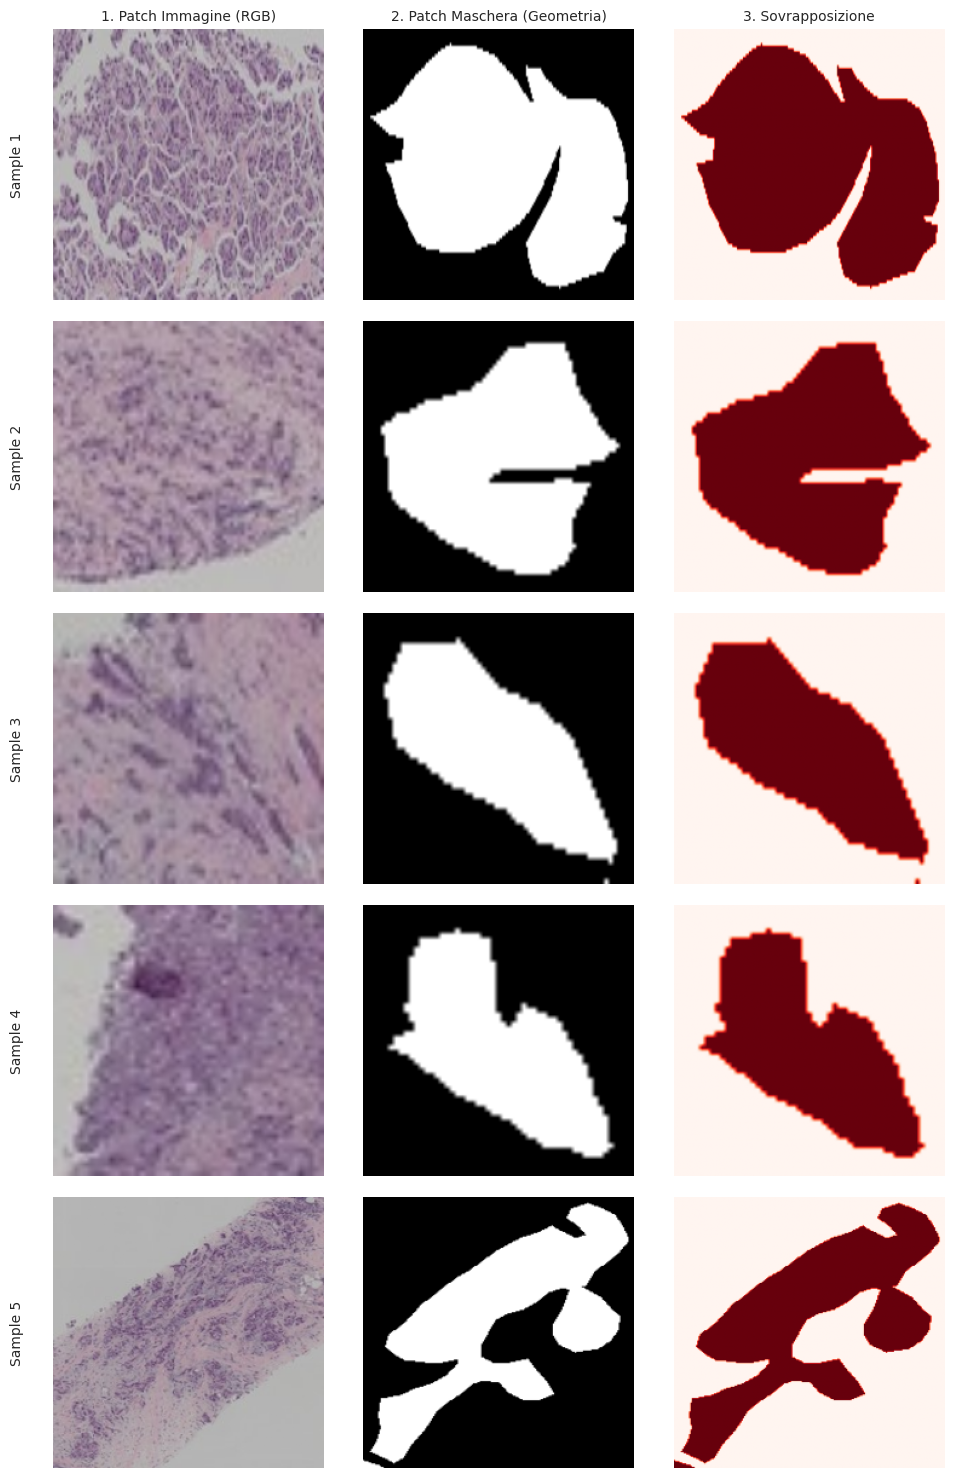

In [7]:
from scipy import ndimage
import random

def unnormalize(img, mean, std):
    # img è un array NumPy (C, H, W)
    img = np.array(img, copy=True)
    for c in range(3):
        # Denormalizza canale per canale
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)

# ASSICURATI DI USARE QUESTA VERSIONE AGGIORNATA
def unnormalize_mask(mask, mean=[0.5], std=[0.5]):
    """
    Denormalizza e riduce il tensor della maschera da (1, H, W) a (H, W).
    """
    # 1. Copia e Denormalizza
    mask = np.array(mask, copy=True) # mask è (1, H, W)
    mask[0] = mask[0] * std[0] + mean[0]

    # 2. Rimuovi l'asse del canale (Cruciale!)
    mask_2d = np.clip(mask[0], 0, 1) # Otteniamo (H, W)

    return mask_2d

def show_parallel_paths_effect(dataset, n=3):
    """
    Visualizza i patch dell'immagine RGB e i corrispondenti patch della maschera
    estratti dal dataset, verificando l'effetto delle trasformazioni.
    """
    # Usiamo gli indici del dataset per campionare, in modo da recuperare le coppie corrette
    indices_to_show = random.sample(range(len(dataset)), min(n, len(dataset)))

    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))

    # Intestazioni delle colonne
    axes[0, 0].set_title("1. Patch Immagine (RGB)", fontsize=10)
    axes[0, 1].set_title("2. Patch Maschera (Geometria)", fontsize=10)
    axes[0, 2].set_title("3. Sovrapposizione", fontsize=10)


    for i, idx in enumerate(indices_to_show):
        # __getitem__ ritorna: patch_img, patch_mask, label, parent
        patch_img_tensor, patch_mask_tensor, label, parent = dataset[idx]

        # --- 1. Processo Immagine (3 Canali) ---
        # Si assume che IMAGENET_MEAN e IMAGENET_STD siano accessibili
        train_img = unnormalize(patch_img_tensor.numpy(), IMAGENET_MEAN, IMAGENET_STD)

        # --- 2. Processo Maschera (1 Canale) ---
        # Si usa la normalizzazione usata per la maschera: mean=[0.5], std=[0.5]
        train_mask = unnormalize_mask(patch_mask_tensor.numpy(), mean=[0.5], std=[0.5])

        # Plot Immagine (colore)
        axes[i, 0].imshow(np.transpose(train_img, (1, 2, 0)))
        axes[i, 0].axis("off")

        # Plot Maschera (scala di grigi)
        # La maschera denormalizzata è (H, W), perfetta per imshow
        axes[i, 1].imshow(train_mask, cmap='gray')
        axes[i, 1].axis("off")

        # Plot Sovrapposizione (per verifica)
        axes[i, 2].imshow(np.transpose(train_img, (1, 2, 0)))
        # La maschera viene applicata come alpha, mappata su un colore
        axes[i, 2].imshow(train_mask, alpha=train_mask * 0.5, cmap="Reds")
        axes[i, 2].axis("off")

        axes[i, 0].text(-30, INPUT_SIZE // 2, f"Sample {i+1}", rotation=90, va='center', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

show_parallel_paths_effect(train_dataset, n=5)


In [8]:
# Define the input shapes and number of classes
# Percorso 1: Immagine RGB
image_input_shape = (3, INPUT_SIZE, INPUT_SIZE)
# Percorso 2: Maschera (Grayscale/Geometria)
mask_input_shape = (1, INPUT_SIZE, INPUT_SIZE)

print(f"Input Shape - Image (RGB): {image_input_shape}")
print(f"Input Shape - Mask (Geo): {mask_input_shape}")
print(f"Number of Classes: {num_classes}")


Input Shape - Image (RGB): (3, 224, 224)
Input Shape - Mask (Geo): (1, 224, 224)
Number of Classes: 4


In [9]:
# Batch size
print("Batch Size:", BATCH_SIZE)


Batch Size: 32


In [10]:
from sklearn.utils.class_weight import compute_class_weight

# calcolo class weights dal TRAIN
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_df["label_index"].values
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05  # oppure 0.0
)

In [11]:
# Training parameters
LEARNING_RATE = 5e-6
EPOCHS = 200
PATIENCE = 20
DROPOUT_RATE = 0.25


print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)
print(class_weights)



Epochs: 200
Batch Size: 32
Learning Rate: 5e-06
Dropout Rate: 0.25
Patience: 20
tensor([0.9667, 0.9206, 0.7117, 2.1091], device='cuda:0')


Training Functions


In [12]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import numpy as np
# Assumo che 'device', 'scaler', 'nn', 'torch.amp.autocast' siano definiti nell'ambiente globale

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # MODIFICA CHIAVE: train_loader ora restituisce 4 elementi (patch_img, patch_mask, targets, parent)
    for image_inputs, mask_inputs, targets, _ in train_loader:

        # 1. Sposta i due input e i target sul dispositivo
        image_inputs = image_inputs.to(device)
        mask_inputs = mask_inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):

            # 2. CHIAMATA MODELLO MODIFICATA: Passa ENTRAMBI gli input
            logits = model(image_inputs, mask_inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * image_inputs.size(0)

        preds = logits.argmax(dim=1)
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = accuracy_score(y_true, y_pred)
    epoch_f1   = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1


def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        # MODIFICA CHIAVE: val_loader ora restituisce 4 elementi
        for image_inputs, mask_inputs, targets, _ in val_loader:

            # 1. Sposta i due input e i target sul dispositivo
            image_inputs = image_inputs.to(device)
            mask_inputs = mask_inputs.to(device)
            targets = targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):

                # 2. CHIAMATA MODELLO MODIFICATA: Passa ENTRAMBI gli input
                logits = model(image_inputs, mask_inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * image_inputs.size(0)

            preds = logits.argmax(dim=1)
            all_predictions.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_predictions)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc  = accuracy_score(y_true, y_pred)
    epoch_f1   = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1


def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        scheduler=None, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):

    history = {
        'train_loss': [],
        'train_f1': [],
        'val_loss': [],
        'val_f1': []
    }

    best_metric = float('-inf') if mode == 'max' else float('inf')
    best_epoch = 0
    patience_counter = 0

    print(f"Training {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        train_loss, _, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )
        val_loss, _, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        if scheduler is not None:
            # Assumo che lo scheduler sia un ReduceLROnPlateau che monitora val_f1
            scheduler.step(val_f1)

        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('F1/Training', train_f1, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('F1/Validation', val_f1, epoch)

        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            print(
                f"Epoch {epoch:3d}/{epochs} | "
                f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f} | "
                f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}"
            )

        current_metric = history[evaluation_metric][-1]
        is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

        if is_improvement:
            best_metric = current_metric
            best_epoch = epoch
            # Assicurati che la directory "models" esista
            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience and patience > 0:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + '_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    elif patience == 0:
        # Se non c'è pazienza, salva l'ultimo modello
        os.makedirs("models", exist_ok=True)
        torch.save(model.state_dict(), "models/" + experiment_name + '_model.pt')

    if writer is not None:
        writer.close()

    return model, history

## Transfer Learning


In [15]:
import torch
import torch.nn as nn
import torchvision

class MobileNetV3DualStream(nn.Module):
    """
    Implementazione Dual-Stream per l'Advice 10/12:
    Un percorso per l'Immagine RGB (3 canali) e un percorso parallelo per la Maschera (1 canale).
    """
    def __init__(self, num_classes, dropout_rate=0.25, freeze_backbone=True):
        super().__init__()

        # --- 1. Percorso Immagine (RGB) ---
        self.image_encoder = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        # *** CORREZIONE: SALVA LA DIMENSIONE DELLE FEATURE QUI ***
        image_in_features = self.image_encoder.classifier[0].in_features
        mask_in_features = image_in_features # Sarà lo stesso valore per entrambi i percorsi

        # Rimuovo la testa di classificazione originale (la sostituisco con Identity)
        self.image_encoder.classifier = nn.Identity()

        # --- 2. Percorso Maschera (Geometria Pura) ---
        self.mask_encoder = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        # MODIFICA ESSENZIALE: Il primo strato convoluzionale deve accettare 1 canale
        original_conv_weight = self.mask_encoder.features[0][0].weight.data

        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv_weight.size(0),
            kernel_size=original_conv_weight.size(2),
            stride=original_conv_weight.size(3),
            padding=1,
            bias=False
        )

        new_conv.weight.data = original_conv_weight.mean(dim=1, keepdim=True)

        self.mask_encoder.features[0][0] = new_conv
        self.mask_encoder.classifier = nn.Identity() # Rimuovo la testa di classificazione


        # --- 3. FREEZING ---
        if freeze_backbone:
            # Congela Image Encoder
            for param in self.image_encoder.parameters():
                param.requires_grad = False
            # Congela Mask Encoder
            for param in self.mask_encoder.parameters():
                param.requires_grad = False
            # Scongela solo lo strato convoluzionale modificato per la maschera
            self.mask_encoder.features[0][0].weight.requires_grad = True


        # --- 4. Testa di Classificazione Fusa ("The summit") ---
        # La dimensione dei feature è la somma dei due percorsi (concatenazione)
        fused_in_features = image_in_features + mask_in_features

        self.classifier = nn.Sequential(
            nn.Linear(fused_in_features, fused_in_features // 2),
            nn.Hardswish(),
            nn.Dropout(dropout_rate),
            nn.Linear(fused_in_features // 2, num_classes)
        )

    def forward(self, image_inputs, mask_inputs):
        # 1. Percorso Immagine (Colore)
        img_features = self.image_encoder(image_inputs)

        # 2. Percorso Maschera (Geometria)
        mask_features = self.mask_encoder(mask_inputs)

        # 3. Fusione (Concatenazione dei feature)
        fused_features = torch.cat((img_features, mask_features), dim=1)

        # 4. Classificazione finale
        logits = self.classifier(fused_features)

        return logits

In [16]:
# Sostituzione del modello a percorso singolo con il modello Dual-Stream
tl_model = MobileNetV3DualStream(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=True # Puoi decidere se congelare entrambi i percorsi
).to(device)

In [17]:
train_tl_loader, val_tl_loader = train_loader, val_loader


In [18]:
# Setup training
experiment_name = "transfer_learning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

optimizer = Lion(
    tl_model.parameters(),
    lr=5e-6,
    weight_decay=1e-2
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=1e-6,
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [19]:
%%time
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_tl_loader,
    val_loader=val_tl_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    scheduler=scheduler,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience= PATIENCE
)

final_f1_score = max(tl_history['val_f1'])
print(f'Maximum f1 score: {final_f1_score}')

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4026, F1=0.2119 | Val: Loss=1.3922, F1=0.1857
Epoch   5/200 | Train: Loss=1.3432, F1=0.3603 | Val: Loss=1.3752, F1=0.3255
Epoch  10/200 | Train: Loss=1.2999, F1=0.3842 | Val: Loss=1.3550, F1=0.3367
Epoch  15/200 | Train: Loss=1.2708, F1=0.4132 | Val: Loss=1.3720, F1=0.3146
Epoch  20/200 | Train: Loss=1.2592, F1=0.4355 | Val: Loss=1.3700, F1=0.3193
Epoch  25/200 | Train: Loss=1.2530, F1=0.4350 | Val: Loss=1.3710, F1=0.3229
Early stopping triggered after 28 epochs.
Best model restored from epoch 8 with val_f1 0.3387
Maximum f1 score: 0.33871910316488535
CPU times: user 3min 14s, sys: 46.7 s, total: 4min 1s
Wall time: 3min 26s


## Fine-Tuning


In [20]:
##Caricamento del modello di Fine Tuning##

train_dataset.transform = train_transform_ft

train_ft_loader = make_loader(train_dataset, BATCH_SIZE, shuffle=True)
val_ft_loader   = make_loader(val_dataset,   BATCH_SIZE, shuffle=False)

val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


ft_model = MobileNetV3DualStream(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=False # Lo scongelamento avverrà manualmente dopo il caricamento
).to(device)

# 3. Caricamento dei pesi (dal training TL precedente)
ft_model.load_state_dict(torch.load("models/transfer_learning_model.pt"))

# --- 4. Scongelamento Selettivo (per Advice 10/12) ---
N_LAYERS_TO_UNFREEZE = 20 # Numero di strati da scongelare (se si intende per layer del blocco 'features')
FREEZE_ALL = True # Rimetto a True per assicurare che si riparta dal congelamento completo

# Congela tutti i parametri di entrambi gli encoder inizialmente
for name, param in ft_model.named_parameters():
    param.requires_grad = False

# Scongelamento dell'Image Encoder (più strati)
backbone_layers_img = list(ft_model.image_encoder.features.children())
for layer in backbone_layers_img[-N_LAYERS_TO_UNFREEZE:]:
    for param in layer.parameters():
        param.requires_grad = True

# Scongelamento del Mask Encoder (meno strati o tutti, a tua discrezione)
# Per esempio, scongela solo l'ultima metà del percorso Maschera:
N_LAYERS_MASK = N_LAYERS_TO_UNFREEZE // 2
backbone_layers_mask = list(ft_model.mask_encoder.features.children())
for layer in backbone_layers_mask[-N_LAYERS_MASK:]:
    for param in layer.parameters():
        param.requires_grad = True

# Scongela sempre la testa di classificazione (classifier fuso)
for param in ft_model.classifier.parameters():
    param.requires_grad = True

# --- 5. Stampa Riepilogo ---
total_params = sum(p.numel() for p in ft_model.parameters())
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Total parameters: 2,520,164
Trainable parameters: 2,515,380
Frozen parameters: 4,784


In [21]:

experiment_name = "fine_tuning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
FT_LEARNING_RATE = 5e-6

optimizer = Lion(
    ft_model.parameters(),
    lr=3e-5,
    weight_decay=1e-2
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=5,
    threshold=1e-3,
    min_lr=1e-6,
)

In [23]:
%%time
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    scheduler=scheduler,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience= PATIENCE
)

final_f1_score = max(ft_history['val_f1'])
print(f'Maximum f1 score: {final_f1_score}')


Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3378, F1=0.3550 | Val: Loss=1.3476, F1=0.3297
Epoch   5/200 | Train: Loss=0.8350, F1=0.6826 | Val: Loss=1.8464, F1=0.2832
Epoch  10/200 | Train: Loss=0.4043, F1=0.9446 | Val: Loss=2.3408, F1=0.2496
Epoch  15/200 | Train: Loss=0.3147, F1=0.9863 | Val: Loss=2.2277, F1=0.2632
Epoch  20/200 | Train: Loss=0.2856, F1=0.9959 | Val: Loss=2.2276, F1=0.2582
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.3297
Maximum f1 score: 0.3296567662109237
CPU times: user 5min 51s, sys: 37 s, total: 6min 28s
Wall time: 6min 6s


Evaluation


In [24]:
from sklearn.metrics import f1_score
import torch

def evaluate_macro_f1(model, loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():

        # MODIFICA CHIAVE: Accetta sia l'immagine che la maschera
        for image_inputs, mask_inputs, labels, _ in loader:

            # Sposta entrambi gli input sul dispositivo
            image_inputs = image_inputs.to(device)
            mask_inputs = mask_inputs.to(device)
            labels = labels.to(device)

            # CHIAMATA MODELLO MODIFICATA: Passa ENTRAMBI gli input
            outputs = model(image_inputs, mask_inputs)

            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    return f1_score(y_true, y_pred, average="macro")

In [25]:
best_model = MobileNetV3DualStream(
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    freeze_backbone=False
).to(device)

# Caricamento dei pesi (questi sono i pesi del modello Dual-Stream FT)
best_model.load_state_dict(torch.load("models/fine_tuning_model.pt"))
best_model.eval()


MobileNetV3DualStream(
  (image_encoder): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
   

In [27]:
# (Assumendo che evaluate_macro_f1 sia stata aggiornata per accettare 2 input)

train_f1 = evaluate_macro_f1(best_model, train_ft_loader, device)
val_f1 = evaluate_macro_f1(best_model, val_ft_loader, device)

print(f"F1 TRAIN (macro): {train_f1:.4f}")
print(f"F1 VAL   (macro): {val_f1:.4f}")


F1 TRAIN (macro): 0.4358
F1 VAL   (macro): 0.3292


Inference on test_data


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image
from scipy import ndimage
import pandas as pd

# Nota: Assumo che 'test_data_dir', 'val_transform', 'make_loader',
# 'best_model', 'device', 'class_names', 'current_dir' siano definiti.

# --- 1. CLASSE DATASET AGGIORNATA PER DUE INPUT ---
class MaskedInferenceDataset(Dataset):
    """
    Dataset per l'Inference che estrae patch di Immagine RGB E Maschera
    per l'architettura Dual-Stream (Advice 10/12).
    """
    def __init__(self, img_dir, transform=None, mask_transform=None, padding=5):
        self.samples = []
        self.transform = transform
        self.mask_transform = mask_transform # NUOVO: Transform per la maschera
        self.img_dir = img_dir
        self.padding = padding

        for img_name in sorted(f for f in os.listdir(img_dir) if f.startswith("img_")):
            img_path  = os.path.join(img_dir, img_name)
            mask_path = os.path.join(img_dir, img_name.replace("img_", "mask_"))

            # Controllo se la maschera esiste nel set di test
            if not os.path.exists(mask_path):
                # Questo caso non dovrebbe verificarsi per questo dataset
                continue

            image = np.array(Image.open(img_path).convert("RGB"))
            mask_raw = np.array(Image.open(mask_path).convert("L")) # Maschera L per il patch
            mask  = (mask_raw > 0) # Maschera booleana per il cropping

            labeled_mask, n_components = ndimage.label(mask)

            for cid in range(1, n_components + 1):
                ys, xs = np.where(labeled_mask == cid)
                if len(xs) < 15:
                    continue

                x1, x2 = xs.min(), xs.max()
                y1, y2 = ys.min(), ys.max()

                h, w = image.shape[:2]

                # Calcola coordinate con padding
                px1 = max(0, x1-padding)
                py1 = max(0, y1-padding)
                px2 = min(w, x2+padding)
                py2 = min(h, y2+padding)

                # Ritaglia sia l'immagine che la maschera!
                patch = image[py1:py2, px1:px2]
                mask_patch = mask_raw[py1:py2, px1:px2] # Riraglia la maschera 8-bit

                # Salva entrambi i patch e il nome dell'immagine
                self.samples.append((patch, mask_patch, img_name)) # MODIFICA: 3 elementi

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        patch, mask_patch_raw, img_name = self.samples[idx]

        # 1. Processo l'Immagine (Colore Grezzo)
        patch_pil = Image.fromarray(patch)
        if self.transform:
            patch_tensor = self.transform(patch_pil)

        # 2. Processo la Maschera (Geometria Pura)
        mask_patch_pil = Image.fromarray(mask_patch_raw, mode='L')
        if self.mask_transform:
            mask_tensor = self.mask_transform(mask_patch_pil)
        else:
            # Fallback se mask_transform è None
            mask_tensor = transforms.ToTensor()(mask_patch_pil)

        # Ritorna patch Immagine, patch Maschera e nome Immagine
        return patch_tensor, mask_tensor, img_name # MODIFICA: Restituisce due tensor

In [31]:
# Riutilizzo delle trasformazioni di validazione per la maschera (definite precedentemente)
# Se non le hai definite, usa questa:
from torchvision import transforms
from collections import defaultdict # Import defaultdict
import torch.nn.functional as F

mask_val_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Assumendo INPUT_SIZE=224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


test_dataset = MaskedInferenceDataset(
    img_dir=test_data_dir,
    transform=val_transform,
    mask_transform=mask_val_transform # NUOVO: Aggiungiamo la trasformazione per la maschera
)

test_loader = make_loader( # Riutilizzo la funzione make_loader
    test_dataset,
    batch_size=32,
    shuffle=False,
)


# --- 3. CICLO DI INFERENCE AGGIORNATO (SOFT VOTING) ---

votes = defaultdict(list)
best_model.eval()

with torch.no_grad():
    # MODIFICA CHIAVE: il loader ora restituisce 3 elementi (patch_img, patch_mask, img_names)
    for patches_img, patches_mask, img_names in test_loader:

        # Sposta entrambi gli input sul dispositivo
        patches_img = patches_img.to(device)
        patches_mask = patches_mask.to(device)

        # CHIAMATA MODELLO MODIFICATA: Passa ENTRAMBI i percorsi
        outputs = F.softmax(best_model(patches_img, patches_mask), dim=1)

        for img, p in zip(img_names, outputs.cpu()):
            votes[img].append(p)

final_preds = {}
for img, plist in votes.items():
    # Soft Voting: Media delle probabilità tra tutti i patch dello stesso oggetto/immagine
    mean_prob = torch.stack(plist).mean(dim=0)
    final_preds[img] = mean_prob.argmax().item()


# --- 4. CREAZIONE SUBMISSION ---

# Ordine stabile per submission
image_names = sorted(final_preds.keys())

submission_df = pd.DataFrame({
    "sample_index": image_names,
    "label": [class_names[final_preds[f]] for f in image_names]
})

# Assumo che current_dir sia definito
os.makedirs(os.path.join(current_dir, "submission"), exist_ok=True)
submission_df.to_csv(
    os.path.join(current_dir, "submission", "MobileNet_dual_stream_voting_dualNet.csv"), # NOME FILE AGGIORNATO
    index=False
)

print(len(submission_df), "righe ? OK")
submission_df.head()

477 righe ? OK


,sample_index,label
0,img_0000.png,Luminal B
1,img_0001.png,Luminal B
2,img_0002.png,Luminal B
3,img_0003.png,Triple negative
4,img_0004.png,Luminal B
